In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm
from statsmodels.formula.api import glm
sns.set_theme()

In [3]:
dataset1 = pd.read_csv('pokemon.csv', index_col=0)

dataset = pd.concat([(dataset1.loc[dataset1['tier'] == 'weak'  ])[:130],
                     (dataset1.loc[dataset1['tier'] == 'medium'])[:120],
                     (dataset1.loc[dataset1['tier'] == 'strong'])[:120]])

dataset.loc[:, 'tier'] = dataset.loc[:, 'tier'].astype('category')
dic = {'weak':1, 'medium':2, 'strong':3}
dataset.loc[:,'tier1'] = [dic[i] for i in dataset[['tier']].values.ravel()]

### Visualization

#### Correlation of Variables

In [4]:
dataset.corr()[['tier1']]

,tier1
num,0.547268
hp,0.478696
atk,0.470910
def,0.370091
spa,0.466586
spd,0.484707
spe,0.274669
Bug,0.078412
Dark,0.112572
Dragon,0.212873


#### BoxPlot Graphs of highly correlated variables

<AxesSubplot:xlabel='tier', ylabel='Count'>

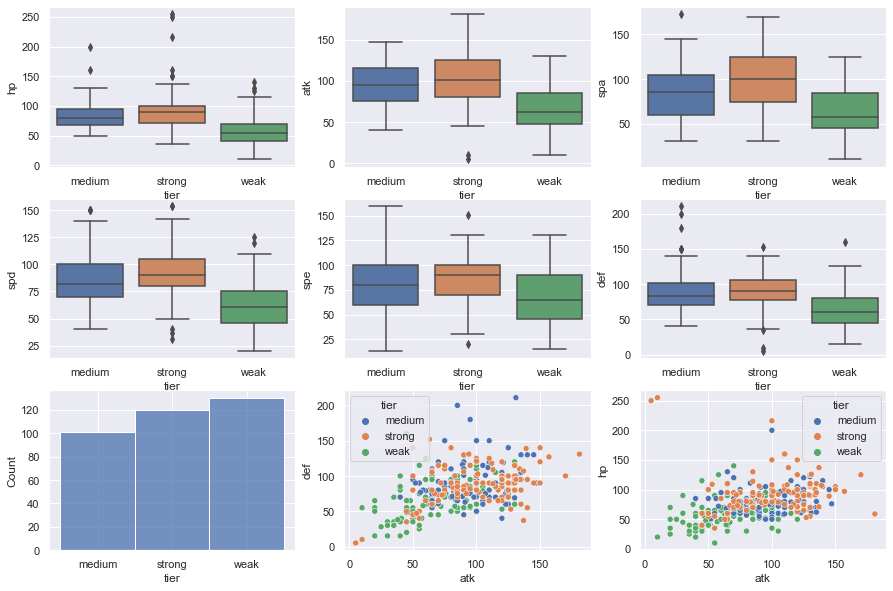

In [5]:
f, axes = plt.subplots(3, 3, figsize = (15,10))
sns.boxplot(y="hp" , x= "tier", data = dataset , ax=axes[0][0])
sns.boxplot(y="atk", x= "tier", data = dataset , ax=axes[0][1])
sns.boxplot(y="spa", x= "tier", data = dataset , ax=axes[0][2])
sns.boxplot(y="spd", x= "tier", data = dataset , ax=axes[1][0])
sns.boxplot(y="spe", x= "tier", data = dataset , ax=axes[1][1])
sns.boxplot(y="def", x= "tier", data = dataset , ax=axes[1][2])
sns.scatterplot(y="hp", x= "atk", data = dataset , ax=axes[2][2], hue="tier")
sns.scatterplot(y="def", x= "atk", data = dataset , ax=axes[2][1], hue="tier")
sns.histplot(dataset.tier, ax=axes[2][0])

,hp,atk,def,spa,spd,spe
weak,57.484615,66.430769,63.992308,62.869231,61.730769,67.092308
medium,82.326733,95.059406,90.049505,86.613861,86.712871,78.366337
strong,92.241667,101.675000,89.966667,98.875000,92.225000,85.008333


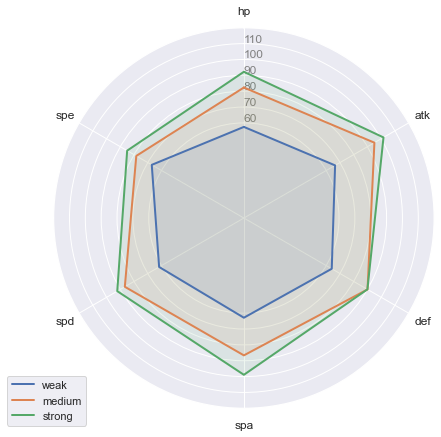

In [6]:
## Create Radar Plot to check average values of the features of the different classes

from math import pi
# Set data
df = pd.DataFrame([np.mean(dataset.loc[dataset['tier'] == 'weak']), 
              np.mean(dataset.loc[dataset['tier'] == 'medium']),
              np.mean(dataset.loc[dataset['tier'] == 'strong'])], index=['weak','medium','strong']).iloc[:, 1:7]
# ------- PART 1: Create background
 
# number of variable
categories=list(df)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
f, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, size=12)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([60,70,80,90, 100, 110], ["60","70","80","90","100", "110"], color="grey", size=12)
plt.ylim(0,120)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
for i in df.index:
    values=df.loc[i].values.flatten().tolist()
    values+=values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=i)
    ax.fill(angles, values, alpha=0.1)
    
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
df

## Classification
### Naive Bayes Classifier

In [33]:
## Using only the highly correlated variables
X = dataset[['hp', 'atk','spa', 'spd']]
y = dataset[['tier']].astype('category').values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [34]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [35]:
acc = sum((y_pred==y_test).astype('float'))/len(((y_pred==y_test).astype('float')))
confmat = (confusion_matrix(y_test, y_pred,labels=['weak','medium','strong'])) 
print("accuracy = ", acc)
pd.DataFrame(confmat, columns=['weak','medium','strong'], index=['weak','medium','strong'])

accuracy =  0.6415094339622641


,weak,medium,strong
weak,32,6,4
medium,8,15,9
strong,1,10,21


In [36]:
## Normalized Confusion Matrix showing percentage of correct predictions per class
pd.DataFrame([np.divide(i,np.sum(i)) for i in confmat], columns=['weak','medium','strong'], index=['weak','medium','strong'])

,weak,medium,strong
weak,0.761905,0.142857,0.095238
medium,0.250000,0.468750,0.281250
strong,0.031250,0.312500,0.656250


### Neural Networks

#### Linear Perceptron (Single Layer Perceptron)

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import Perceptron
scaler = StandardScaler().fit(X_train)
X_train_ = scaler.transform(X_train)  
# apply same transformation to test data
X_test_ = scaler.transform(X_test)

In [83]:
clf = Perceptron(tol=1e-5, class_weight='balanced', penalty='l2', shuffle=True, verbose=True)
clf.fit(X_train_, y_train)
clf.score(X_test_, y_test)
y_pred = clf.predict(X_test_)

-- Epoch 1
Norm: 4.35, NNZs: 4, Bias: -1.739130, T: 245, Avg. loss: 1.013695
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.63, NNZs: 4, Bias: -2.478261, T: 490, Avg. loss: 1.131551
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 2.68, NNZs: 4, Bias: -0.033816, T: 735, Avg. loss: 0.967806
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 3.78, NNZs: 4, Bias: -2.487923, T: 980, Avg. loss: 1.093482
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 1.10, NNZs: 4, Bias: -1.043478, T: 1225, Avg. loss: 0.979828
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2.58, NNZs: 4, Bias: 0.768116, T: 1470, Avg. loss: 1.003418
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 1.76, NNZs: 4, Bias: -2.971014, T: 1715, Avg. loss: 0.981575
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 2.59, NNZs: 4, Bias: -0.710145, T: 1960, Avg. loss: 0.893076
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 1.27, NNZs: 4, Bias: 0.734300, T: 2205, Avg. loss: 1.070594
Total training time: 0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [84]:
acc = sum((y_pred==y_test).astype('float'))/len(((y_pred==y_test).astype('float')))
confmat = (confusion_matrix(y_test, y_pred,labels=['weak','medium','strong'])) 
print("accuracy = ", acc)
pd.DataFrame(confmat, columns=['weak','medium','strong'], index=['weak','medium','strong'])

accuracy =  0.6037735849056604


,weak,medium,strong
weak,32,8,2
medium,9,8,15
strong,4,4,24


In [85]:
## Normalized Confusion Matrix showing percentage of correct predictions per class
pd.DataFrame([np.divide(i,np.sum(i)) for i in confmat], columns=['weak','medium','strong'], index=['weak','medium','strong'])

,weak,medium,strong
weak,0.761905,0.190476,0.047619
medium,0.281250,0.250000,0.468750
strong,0.125000,0.125000,0.750000


#### MultiLayer Perceptron Classifier

In [113]:
clf = MLPClassifier(random_state=10,solver='sgd',activation='identity', batch_size=4, power_t=0.7, verbose=True, tol=0.9)
clf.fit(X_train_, y_train)
y_pred = clf.predict(X_test_)
clf.score(X_test_, y_test)

Iteration 1, loss = 0.91444148
Iteration 2, loss = 0.81909932
Iteration 3, loss = 0.80300917
Iteration 4, loss = 0.79699259
Iteration 5, loss = 0.79572253
Iteration 6, loss = 0.79517203
Iteration 7, loss = 0.79532656
Iteration 8, loss = 0.79456505
Iteration 9, loss = 0.79389597
Iteration 10, loss = 0.79362814
Iteration 11, loss = 0.79464818
Iteration 12, loss = 0.79405282
Training loss did not improve more than tol=0.900000 for 10 consecutive epochs. Stopping.


0.6226415094339622

In [114]:
acc = sum((y_pred==y_test).astype('float'))/len(((y_pred==y_test).astype('float')))
confmat = (confusion_matrix(y_test, y_pred,labels=['weak','medium','strong'])) 
print("accuracy = ", acc)
pd.DataFrame(confmat, columns=['weak','medium','strong'], index=['weak','medium','strong'])

accuracy =  0.6226415094339622


,weak,medium,strong
weak,32,7,3
medium,9,4,19
strong,1,1,30


In [115]:
## Normalized Confusion Matrix showing percentage of correct predictions per class
pd.DataFrame([np.divide(i,np.sum(i)) for i in confmat], columns=['weak','medium','strong'], index=['weak','medium','strong'])

,weak,medium,strong
weak,0.761905,0.166667,0.071429
medium,0.281250,0.125000,0.593750
strong,0.031250,0.031250,0.937500


### Conclusion
1. Class Imbalance was a big problem for predictions. Therefore undersampling was used to balance the data.
2. From the Radar Plot, it is evident that the feature means are very close for medium and strong classes, while difference between feature means of weak and medium is higher. Which is a reason behind most of medium tiers being classified as strong. 
2. All of the methods seemed to be giving a good accuracy for Strong and Weak Classes as they had more data. Medium Tier had very less data and thus had a lower accuracy.
3. Naive Bayes Classifier had a good overall performance, with good predictions on Weak Tier as well.
4. Linear Perceptron and MultiLayer Perceptron had high accuracies on Weak and Strong Classes, but very less accuracy on Medium.